## Reference
__Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.__

In [2]:
import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
cifar10_dir = r"D:\Data_and_AI\Datasets\cifar10\cifar-10-batches-py" 

In [5]:
def unpickle(file):
    """Load CIFAR-10 batch file."""
    with open(file, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')  # Load with byte encoding
    return data_dict

In [6]:
x_train = []
y_train = []

for i in range(1, 6):  #to get through the 5 training batches
    batch = unpickle(os.path.join(cifar10_dir, f"data_batch_{i}"))
    x_train.append(batch[b'data'])   # Image data
    y_train.append(batch[b'labels']) # Labels

x_train = np.concatenate(x_train, axis=0)  # Stack all batches
y_train = np.concatenate(y_train, axis=0)  # Stack labels

# Load test batch
test_batch = unpickle(os.path.join(cifar10_dir, "test_batch"))
x_test = test_batch[b'data']
y_test = np.array(test_batch[b'labels'])

# CIFAR-10 has 10 classes
label_names = unpickle(os.path.join(cifar10_dir, "batches.meta"))[b'label_names']
label_names = [label.decode('utf-8') for label in label_names]  # Convert byte strings to normal strings

# Reshape image data to (num_images, 32, 32, 3)
x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert from (N, 3, 32, 32) to (N, 32, 32, 3)
x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

print(f"Training Set: {x_train.shape}, Test Set: {x_test.shape}")
print(f"Classes: {label_names}")

Training Set: (50000, 32, 32, 3), Test Set: (10000, 32, 32, 3)
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
# Split the original training set (50,000 images) into Train (80%) and Validation (20%)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print dataset shapes
print(f"New Training Set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Validation Set: {x_val.shape}, Labels: {y_val.shape}")
print(f"Test Set (unchanged): {x_test.shape}, Labels: {y_test.shape}")

New Training Set: (40000, 32, 32, 3), Labels: (40000,)
Validation Set: (10000, 32, 32, 3), Labels: (10000,)
Test Set (unchanged): (10000, 32, 32, 3), Labels: (10000,)


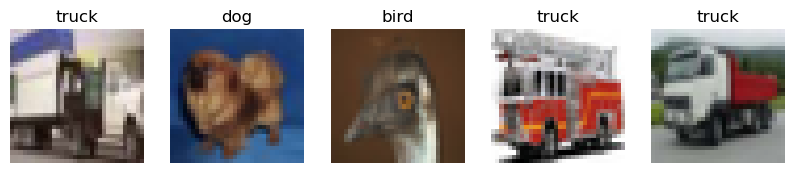

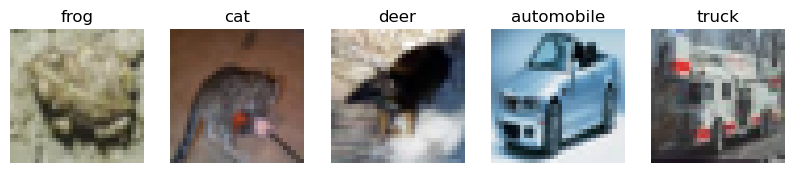

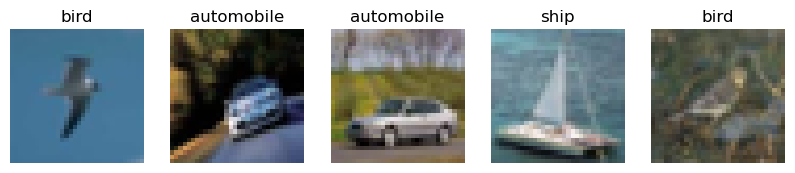

In [8]:
def show_images(images, labels, title, num_images=5):
    plt.figure(figsize=(10, 2))  # Set figure size
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        index = np.random.randint(0, len(images))  # Pick a random index
        plt.imshow(images[index])  
        plt.title(label_names[labels[index]])  
        plt.axis("off")  # Hide axes
    plt.show()

# Show images from each dataset
show_images(x_train, y_train, "Training Set")
show_images(x_val, y_val, "Validation Set")
show_images(x_test, y_test, "Test Set")

In [9]:
# One-hot encode labels for training, validation, and test sets
y_train_cat = to_categorical(y_train, num_classes=10)
y_val_cat = to_categorical(y_val, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

## Models

### Model 1

In [51]:
model = Sequential([
    layers.Input(shape=(32, 32, 3)),

    # Convolutional layer
    layers.Conv2D(filters=300, kernel_size=(3, 3), activation='relu', padding='same'),

    # Max-pooling layer
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Dropout after the first pooling layer
    layers.Dropout(0.25),

    # Convolutional layer
    layers.Conv2D(filters=300, kernel_size=(2, 2), activation='relu', padding='same'),

    # Max-pooling layer
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Dropout after the second pooling layer
    layers.Dropout(0.25),

    # Convolutional layer
    layers.Conv2D(filters=300, kernel_size=(3, 3), activation='relu', padding='same'),

    # Max-pooling layer
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Dropout after the third pooling layer
    layers.Dropout(0.25),

    # Convolutional layer
    layers.Conv2D(filters=300, kernel_size=(2, 2), activation='relu', padding='same'),

    # Max-pooling layer
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Dropout after the fourth pooling layer
    layers.Dropout(0.25),

    # Flatten the output for the fully connected layers
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(units=300, activation='relu'),

    # Dropout before the first fully connected layer
    layers.Dropout(0.5),

    # Fully connected layer
    layers.Dense(units=100, activation='relu'),

    # Dropout before the second fully connected layer
    layers.Dropout(0.5),

    # Output layer
    layers.Dense(units=10, activation='softmax')
])

In [53]:
model.compile(optimizer=Adam(learning_rate= 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 300)         │           8,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 300)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 300)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 300)         │         360,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 300)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 300)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 300)           │         810,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 300)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 300)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 300)           │         360,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 300)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 300)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 300)                 │         360,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,930,710 (7.37 MB)

 Trainable params: 1,930,710 (7.37 MB)

 Non-trainable params: 0 (0.00 B)

None


In [55]:
# Implement Learning Rate Scheduling
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Implement Early Stopping with patience of 3 (you can adjust this)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [57]:
history = model.fit(
    x_train, y_train_cat,
    epochs=30, # You can adjust the number of epochs
    batch_size=64,
    validation_data=(x_val, y_val_cat),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/30
263/625 ━━━━━━━━━━━━━━━━━━━━ 2:57 489ms/step - accuracy: 0.1289 - loss: 2.2583

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# Generate predictions for the test set
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_names))

# Confusion Matrix
conf_mat_5 = sns.heatmap(
    pd.DataFrame(confusion_matrix(y_test, y_pred_classes),
                 index=label_names, columns=label_names),
    annot=True, fmt='d', cmap='Blues'
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()